### Import Libraries
Import necessary libraries for data processing, model training, and evaluation.

In [34]:
import pandas as pd
import re
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
import mlflow

### Load and Inspect Data
Load the dataset and inspect the first few rows to understand its structure.

In [35]:
df=pd.read_csv('/kaggle/input/news.csv')
df.head()


,date,news,neg,neu,pos,compound,sentiment
0,2007-07-07,It was a long antipodean night. While there’s ...,0.059000,0.87800,0.064000,0.051600,POSITIVE
1,2007-07-07,In Mexico there are no licensing or registrati...,0.044000,0.95600,0.000000,-0.296000,NEGATIVE
2,2007-07-07,The government has until Monday to protect the...,0.000000,0.89400,0.106000,0.381800,POSITIVE
3,2007-07-07,A record-breaking heat wave in the Southwest i...,0.197505,0.66149,0.141005,0.997491,POSITIVE
4,2007-07-07,England started its Live Earth concert at Wemb...,0.033000,0.94500,0.022000,-0.177900,NEGATIVE


In [36]:
# Enable MLflow autologging
mlflow.tensorflow.autolog()

In [37]:
df['sentiment'].value_counts()

sentiment
NEGATIVE    217443
POSITIVE    210039
Name: count, dtype: int64

In [38]:
# Check for missing values
print(df.isnull().sum())

date         0
news         0
neg          0
neu          0
pos          0
compound     0
sentiment    0
dtype: int64


In [39]:
# Check for duplicate headlines
print(f"Duplicates: {df.duplicated().sum()}")

Duplicates: 0


### Preprocess Text Data
Clean and preprocess the text data for model input.

In [40]:
df.drop_duplicates(inplace=True)

In [41]:
df.shape

(427482, 7)

In [42]:
# Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    text = ' '.join([word for word in text.split() if word not in STOPWORDS])
    return text.strip()

In [43]:
df["clean_news"] = df["news"].apply(clean_text)
df.drop(columns=["news"], inplace=True)

In [44]:
# Define Financial Keywords
financial_keywords_positive = [
    "profits", "growth", "investment", "stock rise", "economic stimulus", "bull market",
    "revenue increase", "earnings beat", "expansion", "merger", "acquisition", "dividends",
    "IPO", "venture capital", "funding round", "market surge", "record high", "economic boom",
    "strong earnings", "recovery", "job creation"
]

financial_keywords_negative = [
    "inflation", "collapse", "recession", "bankruptcy", "debt", "bear market",
    "stock crash", "economic downturn", "losses", "default", "layoffs", "credit crisis",
    "interest rate hike", "market drop", "trade war", "stagflation", "credit downgrade",
    "federal reserve tightening", "slowdown", "budget deficit", "job cuts"
]

def calculate_financial_importance(news_text):
    pos_score = sum(1 for word in financial_keywords_positive if word in news_text)
    neg_score = sum(-1 for word in financial_keywords_negative if word in news_text)
    return pos_score + neg_score

# Apply Financial Importance Score
df['financial_importance'] = df['clean_news'].apply(calculate_financial_importance)

# Ranking System
df["rank_score"] = (df["pos"] * 2) + (df["neu"] * 1) - (df["neg"] * 3) + (df["compound"] * 5) + (df["financial_importance"] * 10)
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Define the percentile range for clipping
lower_bound, upper_bound = np.percentile(df["rank_score"], [5, 95])

# Clip out extreme values
df["rank_score_clipped"] = df["rank_score"].clip(lower=lower_bound, upper=upper_bound)

# Apply Min-Max Scaling to (-10, 10)
scaler = MinMaxScaler(feature_range=(-10, 10))
df["rank_scaled"] = scaler.fit_transform(df[["rank_score_clipped"]])

# Convert to integers for clean ranking
df["rank_scaled"] = df["rank_scaled"].round().astype(int)

In [45]:
df.head()

,date,neg,neu,pos,compound,sentiment,clean_news,financial_importance,rank_score,rank_score_clipped,rank_scaled
0,2007-07-07,0.059000,0.87800,0.064000,0.051600,POSITIVE,long antipodean night theres telling whats ref...,0,1.087000,1.087000,0
1,2007-07-07,0.044000,0.95600,0.000000,-0.296000,NEGATIVE,mexico licensing registration requirements rea...,0,-0.656000,-0.656000,-3
2,2007-07-07,0.000000,0.89400,0.106000,0.381800,POSITIVE,government monday protect redacted names baseb...,0,3.015000,3.015000,4
3,2007-07-07,0.197505,0.66149,0.141005,0.997491,POSITIVE,recordbreaking heat wave southwest pushing nor...,0,5.338441,5.338441,8
4,2007-07-07,0.033000,0.94500,0.022000,-0.177900,NEGATIVE,england started live earth concert wembley sta...,0,0.000500,0.000500,-2


In [46]:
df["rank_scaled"].value_counts()

rank_scaled
 10    41720
 9     32940
 4     31126
 5     30838
 7     27644
-10    27030
 6     26256
 8     25870
 3     20007
-4     18626
-5     17353
-6     16831
-7     16230
-8     14793
-3     14774
 2     14037
-9     13099
 1     11738
-2     10698
-1      8440
 0      7432
Name: count, dtype: int64

In [47]:
df=df.drop(columns=['rank_score','rank_score_clipped','financial_importance'])
df.head()

,date,neg,neu,pos,compound,sentiment,clean_news,rank_scaled
0,2007-07-07,0.059000,0.87800,0.064000,0.051600,POSITIVE,long antipodean night theres telling whats ref...,0
1,2007-07-07,0.044000,0.95600,0.000000,-0.296000,NEGATIVE,mexico licensing registration requirements rea...,-3
2,2007-07-07,0.000000,0.89400,0.106000,0.381800,POSITIVE,government monday protect redacted names baseb...,4
3,2007-07-07,0.197505,0.66149,0.141005,0.997491,POSITIVE,recordbreaking heat wave southwest pushing nor...,8
4,2007-07-07,0.033000,0.94500,0.022000,-0.177900,NEGATIVE,england started live earth concert wembley sta...,-2


In [48]:
# Encode labels
label_mapping = {"NEGATIVE": 0, "POSITIVE": 1}
df["label"] = df["sentiment"].map(label_mapping)
df.drop(columns=["sentiment"], inplace=True)
df.head()

,date,neg,neu,pos,compound,clean_news,rank_scaled,label
0,2007-07-07,0.059000,0.87800,0.064000,0.051600,long antipodean night theres telling whats ref...,0,1
1,2007-07-07,0.044000,0.95600,0.000000,-0.296000,mexico licensing registration requirements rea...,-3,0
2,2007-07-07,0.000000,0.89400,0.106000,0.381800,government monday protect redacted names baseb...,4,1
3,2007-07-07,0.197505,0.66149,0.141005,0.997491,recordbreaking heat wave southwest pushing nor...,8,1
4,2007-07-07,0.033000,0.94500,0.022000,-0.177900,england started live earth concert wembley sta...,-2,0


### Sentiment Rank Distribution
Bar plot showing the distribution of sentiment rank values.

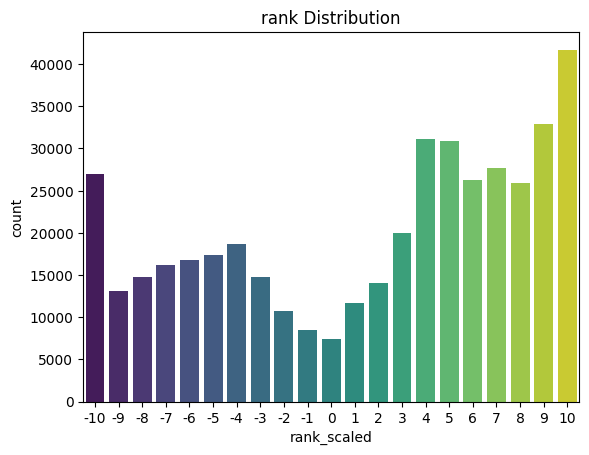

In [49]:
# Visualization
sns.countplot(x=df["rank_scaled"], palette="viridis")
plt.title("rank Distribution")
plt.show()

### Word Cloud for Positive Sentiment
Word cloud highlighting the most common words in positive sentiment articles.

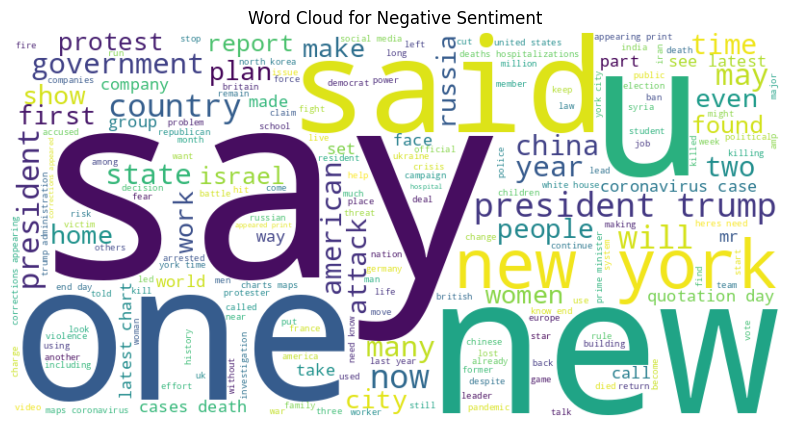

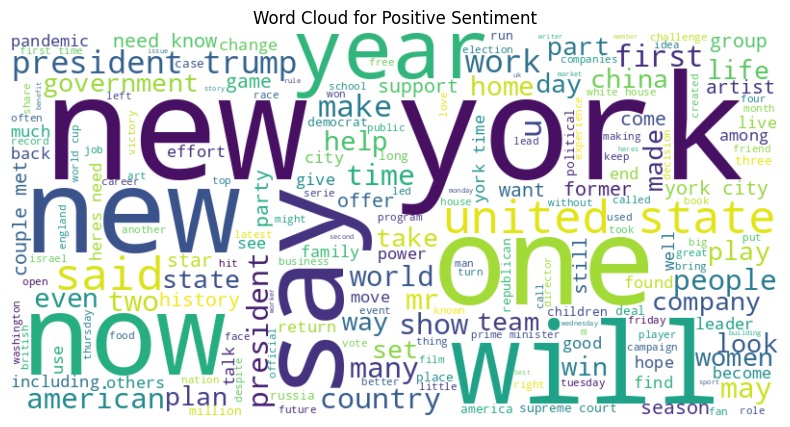

In [50]:
from wordcloud import WordCloud, STOPWORDS

# Define stopwords
stopwords = set(STOPWORDS)

# Generate and plot WordCloud for each sentiment
for sentiment, label in label_mapping.items():
    text = ' '.join(df[df["label"] == label]["clean_news"])

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=stopwords
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud for {sentiment.capitalize()} Sentiment")
    plt.show()


In [51]:
import mlflow
mlflow.tensorflow.autolog(log_models=True, log_datasets=False, disable_for_unsupported_versions=True)

### Tokenization

Tokenize the text data using the BERT tokenizer. This step converts raw text into input IDs, attention masks, and token type IDs for BERT model input.

In [53]:
# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the text
def encode_text(texts, max_len=128):
    return tokenizer(
        texts.tolist(), 
        max_length=max_len, 
        truncation=True, 
        padding='max_length', 
        return_tensors='tf'
    )

encoded_data = encode_text(df["clean_news"])
input_ids = encoded_data['input_ids']
attention_mask = encoded_data['attention_mask']

# Prepare data for training
y_sentiment = df["label"].values
y_rank = df["rank_scaled"].values

X_train, X_test, y_train_sent, y_test_sent, y_train_rank, y_test_rank = train_test_split(
    input_ids.numpy(), y_sentiment, y_rank, test_size=0.2, random_state=42, stratify=y_sentiment
)

# Attention masks for train and test
train_mask, test_mask = train_test_split(
    attention_mask.numpy(), test_size=0.2, random_state=42)